# Constraining the radio pulse periodicity in GLEAMX J162759.5-523504.3 
[Hurley-Walker et al.]()

Given that the pulse shape changes and the very non-uniform sampling of the time-series, we perform this via phase dispersion minimization.

Given the rather long baseline of coverage and high number of pulses, the uncertainty in the period is very small. To estimate the uncertainty, we estimate the 1-$\sigma$ scatter in the power spectrum around the best period. For the smooth spectral profile (from which the scatter is estimated) we use a generalized Savitzky-Golay filter. This choice is rather arbitrary (any well-defined moving average, or smoothed profile should be sufficient and will not change the result). A generalized SG is a rather well-behaved and adjustable filter, hence the preference.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pylab as plt
import P4J
from astropy.io import ascii
from astropy.time import Time
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='serif')
from scipy.signal import savgol_filter

def gen_savgol(x, y, window, polynom):
    """
    Applies a Savitzky-Golay filter to y with non-uniform spacing as defined in x

    This is based on 
    https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length
        as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array of float
        The smoothed y values
    """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))     # Matrix
    tA = np.empty((polynom, window))    # Transposed matrix
    t = np.empty(window)                # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

## Data

Data are time-series constructed from MWA observations.

In [3]:
data = ascii.read('periodogram_input.txt',names=('time','flx'))
time = data['time']- data['time'][0]
rate = data['flx']
# Flux uncertainty is negligible and uniform
rate_er = np.ones(len(time))*0.1

## Periodogram analysis

### Part I - large frequency sweep to identify the best peaks

In [5]:
powspec_coarse = P4J.periodogram(method='LKSL')
powspec_coarse.set_data(time, rate, rate_er)
powspec_coarse.frequency_grid_evaluation(fmin=1/2000, fmax=1/500, fresolution=1e-8)
powspec_coarse.finetune_best_frequencies(fresolution=1e-9, n_local_optima=3)
freq_coarse, per_coarse = powspec_coarse.get_periodogram()
fbest_coarse, pbest_coarse = powspec_coarse.get_best_frequencies()

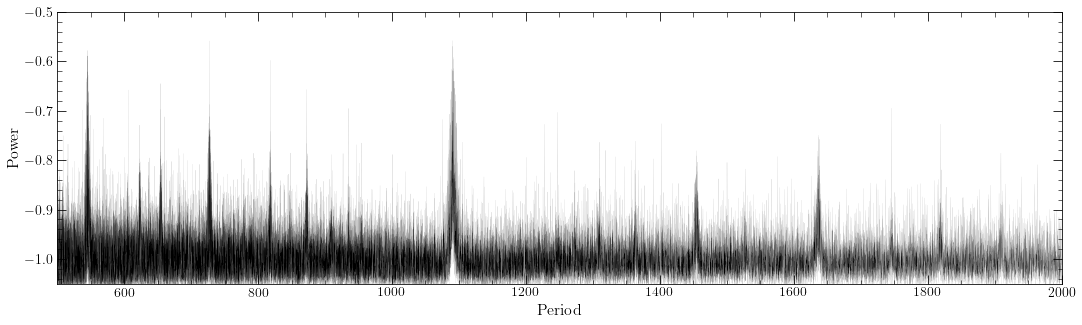

In [11]:
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(1/freq_coarse, per_coarse,color='k',alpha=1,lw=0.05)
ax.set_xlim(500,2000)
ax.set_ylim(-1.05,-0.5)
ax.set_xlabel('Period (s)',fontsize=16)
ax.set_ylabel('Power',fontsize=16)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', length=9)
ax.tick_params(axis='both', which='minor', length=4.5)
ax.tick_params(axis='both', which='both',direction='in',right=True,top=True)

### Part II - Zooming in on the best peak
After exploring the harmonics and similarly strong peaks, the one at ~1900 s seems to be indeed the strongest peak. 

In [21]:
my_per = P4J.periodogram(method='LKSL')
my_per.set_data(time, rate, rate_er)
my_per.frequency_grid_evaluation(fmin=1/(1091.18), fmax=1/(1091.16), fresolution=1e-10)
my_per.finetune_best_frequencies(fresolution=1e-11, n_local_optima=1)
freq, per = my_per.get_periodogram()
fbest, pbest = my_per.get_best_frequencies()

## Analysis for point estimation and uncertainty:
svg_smoothed = gen_savgol(1/freq,per,101,5)
noise = np.std(per-svg_smoothed)

# Point estimate for the smoothed spectrum
period_array = 1/freq
best_p = period_array[svg_smoothed.argmax()]

# Lower limit
period_array_lower_half = period_array[period_array < best_p]
power_array_lower_half = svg_smoothed[period_array < best_p]
best_p_lower_bound = period_array_lower_half[abs(power_array_lower_half - power_array_lower_half.max()+noise).argmin()]

# Upper limit
period_array_upper_half = period_array[period_array > best_p]
power_array_upper_half = svg_smoothed[period_array > best_p]
best_p_upper_bound = period_array_upper_half[abs(power_array_upper_half - power_array_upper_half.max()+noise).argmin()]

print(f'Best period: {best_p}(-{best_p-best_p_lower_bound}/+-{best_p_upper_bound-best_p})')

Best period: 1091.170654296875(-0.001953125/+-0.001708984375)


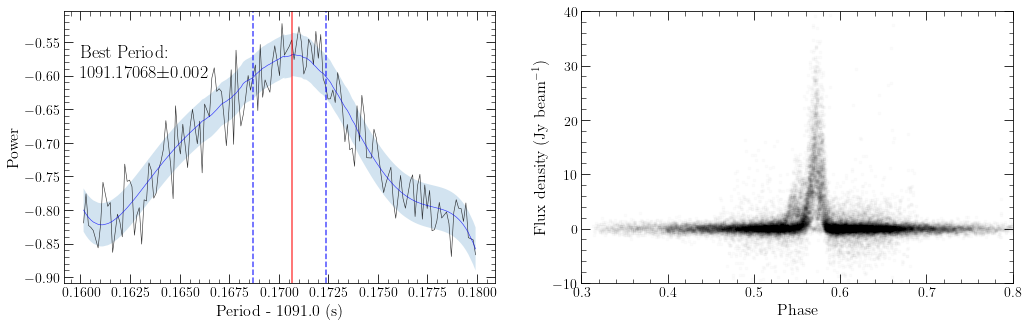

In [23]:
offset = 1091  # for plotting the period axis

fig = plt.figure(figsize=(17, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(1/freq - offset, per,color='k',alpha=0.8,lw=0.6)
ax.plot(1/freq - offset, svg_smoothed,color='b',alpha=0.8,lw=0.6)
ax.fill_between(1/freq - offset,svg_smoothed - noise, svg_smoothed + noise,alpha=0.2)
ax.axvline(best_p-offset,linestyle='-',color='red',alpha=0.7)
ax.axvline(best_p_lower_bound-offset,linestyle='--',color='b',alpha=0.7)
ax.axvline(best_p_upper_bound-offset,linestyle='--',color='b',alpha=0.7)
ax.text(0.16,-0.6,f'Best Period:\n{round(1/freq[svg_smoothed.argmax()],5)}$\pm$0.002',fontsize=18)

ax.set_xlabel('Period - 1091.0 (s)',fontsize=16)
ax.set_ylabel('Power',fontsize=16)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', length=9)
ax.tick_params(axis='both', which='minor', length=4.5)
ax.tick_params(axis='both', which='both',direction='in',right=True,top=True)

ax = fig.add_subplot(1, 2, 2)
phase = np.mod(time+0.5/fbest, 1.0/fbest)*fbest
idx = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase), np.sort(phase)+1.0]), 
            np.concatenate([rate[idx], rate[idx]]),
            np.concatenate([rate_er[idx], rate_er[idx]]), fmt='.k',alpha=0.01,elinewidth=0.5)
#ax.set_title('Best period',fontsize=16)
ax.set_xlabel('Phase',fontsize=16)
ax.set_ylabel('Flux density (Jy beam$^{-1}$)',fontsize=16)
ax.set_xlim([0.3, 0.8])
ax.set_ylim([-10, 40])
#plt.grid()
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', length=9)
ax.tick_params(axis='both', which='minor', length=4.5)
ax.tick_params(axis='both', which='both',direction='in',right=True,top=True)
fig.savefig('mwatransient_PDM.jpg',dpi=300,bbox_inches='tight')